# Link bản báo cáo:

# Import Library

In [2]:
import pandas as pd
import datetime as dt
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import math
import matplotlib.pyplot as plt

# Preprocessing 

In [3]:
df = pd.read_csv('/kaggle/input/traindata/FPT.csv', parse_dates=['Date/Time'])
df.head()

,Ticker,Date/Time,Open,High,Low,Close,Volume,Open Interest
0,FPT,2018-12-25 09:15:00,30.89,30.89,30.89,30.89,35410,0
1,FPT,2018-12-25 09:16:00,30.81,30.81,30.81,30.81,190,0
2,FPT,2018-12-25 09:17:00,30.74,30.81,30.74,30.74,1120,0
3,FPT,2018-12-25 09:18:00,30.74,30.74,30.74,30.74,2120,0
4,FPT,2018-12-25 09:19:00,30.74,30.74,30.74,30.74,22500,0


In [4]:
df.shape

(97406, 8)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97406 entries, 0 to 97405
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Ticker         97406 non-null  object        
 1   Date/Time      97406 non-null  datetime64[ns]
 2   Open           97406 non-null  float64       
 3   High           97406 non-null  float64       
 4   Low            97406 non-null  float64       
 5   Close          97406 non-null  float64       
 6   Volume         97406 non-null  int64         
 7   Open Interest  97406 non-null  int64         
dtypes: datetime64[ns](1), float64(4), int64(2), object(1)
memory usage: 5.9+ MB


In [6]:
df.describe()

,Open,High,Low,Close,Volume,Open Interest
count,97406.000000,97406.000000,97406.000000,97406.000000,9.740600e+04,97406.0
mean,45.071630,45.090138,45.051430,45.071631,8.044173e+03,0.0
std,6.359803,6.364950,6.354245,6.359799,1.753203e+04,0.0
min,30.250000,30.250000,30.220000,30.250000,1.000000e+01,0.0
25%,39.740000,39.740000,39.700000,39.740000,7.500000e+02,0.0
50%,46.950000,46.950000,46.950000,46.950000,2.960000e+03,0.0
75%,49.200000,49.250000,49.170000,49.200000,8.960000e+03,0.0
max,58.400000,58.500000,58.400000,58.400000,1.255930e+06,0.0


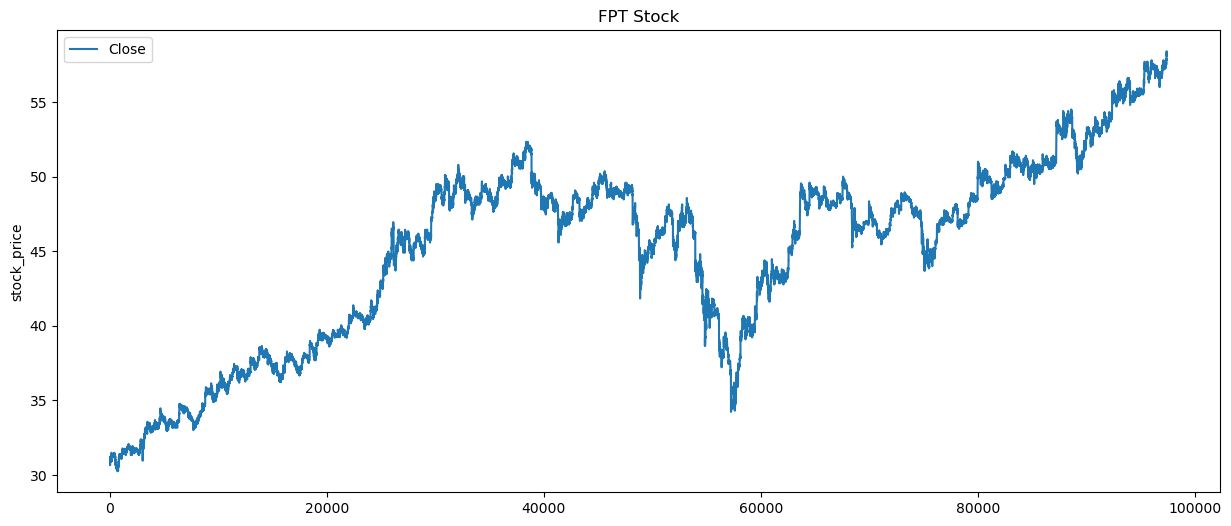

In [7]:
df[['Close']].plot(figsize=(15, 6))
plt.ylabel("stock_price")
plt.title("FPT Stock")
plt.show()

In [8]:
df1 = df.reset_index()['Close']
df1

0        30.89
1        30.81
2        30.74
3        30.74
4        30.74
         ...  
97401    58.20
97402    58.20
97403    58.20
97404    58.10
97405    58.10
Name: Close, Length: 97406, dtype: float64

In [9]:
# scaler 
scaler = MinMaxScaler(feature_range=(0,1))
df1 = scaler.fit_transform(np.array(df1).reshape(-1,1))

In [10]:
df1

array([[0.02273535],
       [0.01989343],
       [0.01740675],
       ...,
       [0.9928952 ],
       [0.98934281],
       [0.98934281]])

In [11]:
# split data train & test
training_size = int(len(df1)*0.8)
test_size = len(df1) - training_size
train_data, test_data = df1[0:training_size,:], df1[training_size:len(df1), :1]

In [12]:
len(train_data)

77924

In [13]:
len(test_data)

19482

In [14]:
def create_dataset(data, time_step=1):
    X, Y = [], []
    for i in range(len(data)-time_step-1):
        a = data[i:(i+time_step), 0]
        X.append(a)
        Y.append(data[i+time_step, 0])
    return np.array(X), np.array(Y)

In [15]:
time_step = 100
X_train, y_train = create_dataset(train_data,time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [16]:
print(X_train.shape), print(y_train.shape)

(77823, 100)
(77823,)


(None, None)

In [17]:
print(X_test.shape), print(y_test.shape)

(19381, 100)
(19381,)


(None, None)

In [18]:
# reshape input 
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [19]:
X_train

array([[[0.02273535],
        [0.01989343],
        [0.01740675],
        ...,
        [0.02273535],
        [0.02273535],
        [0.02664298]],

       [[0.01989343],
        [0.01740675],
        [0.01740675],
        ...,
        [0.02273535],
        [0.02664298],
        [0.02664298]],

       [[0.01740675],
        [0.01740675],
        [0.01740675],
        ...,
        [0.02664298],
        [0.02664298],
        [0.02806394]],

       ...,

       [[0.62699822],
        [0.62699822],
        [0.62699822],
        ...,
        [0.62877442],
        [0.62877442],
        [0.62877442]],

       [[0.62699822],
        [0.62699822],
        [0.62877442],
        ...,
        [0.62877442],
        [0.62877442],
        [0.62877442]],

       [[0.62699822],
        [0.62877442],
        [0.62699822],
        ...,
        [0.62877442],
        [0.62877442],
        [0.62877442]]])

# MODEL


In [20]:
# LSTM for time-series
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 50)           10400     
                                                                 
 lstm_1 (LSTM)               (None, 100, 50)           20200     
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [21]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5)
model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=100,batch_size=64,verbose=1, callbacks=[early_stopping])

Epoch 1/100
1216/1216 [==============================] - 35s 18ms/step - loss: 5.5549e-04 - val_loss: 1.2202e-04
Epoch 2/100
1216/1216 [==============================] - 20s 17ms/step - loss: 3.5591e-05 - val_loss: 1.6404e-04
Epoch 3/100
1216/1216 [==============================] - 20s 16ms/step - loss: 3.3474e-05 - val_loss: 5.9271e-05
Epoch 4/100
1216/1216 [==============================] - 20s 17ms/step - loss: 3.1317e-05 - val_loss: 5.8138e-05
Epoch 5/100
1216/1216 [==============================] - 20s 16ms/step - loss: 2.3925e-05 - val_loss: 2.6719e-05
Epoch 6/100
1216/1216 [==============================] - 20s 16ms/step - loss: 2.1297e-05 - val_loss: 1.1093e-04
Epoch 7/100
1216/1216 [==============================] - 20s 16ms/step - loss: 1.6351e-05 - val_loss: 1.0089e-05
Epoch 8/100
1216/1216 [==============================] - 20s 17ms/step - loss: 1.3326e-05 - val_loss: 9.3458e-06
Epoch 9/100
1216/1216 [==============================] - 20s 16ms/step - loss: 1.0589e-05 - val_

In [22]:
# check performance
train_pred = model.predict(X_train)
test_pred = model.predict(X_test)

606/606 [==============================] - 4s 6ms/step


In [23]:
# Transform back to original form 
train_pred = scaler.inverse_transform(train_pred)
test_pred = scaler.inverse_transform(test_pred)

In [24]:
train_pred

array([[30.917242],
       [30.951239],
       [30.987816],
       ...,
       [47.91176 ],
       [47.911617],
       [47.911438]], dtype=float32)

In [25]:
math.sqrt(mean_squared_error(y_train, train_pred))

43.131974520008406

In [26]:
math.sqrt(mean_squared_error(y_test,test_pred))

51.496308355181895

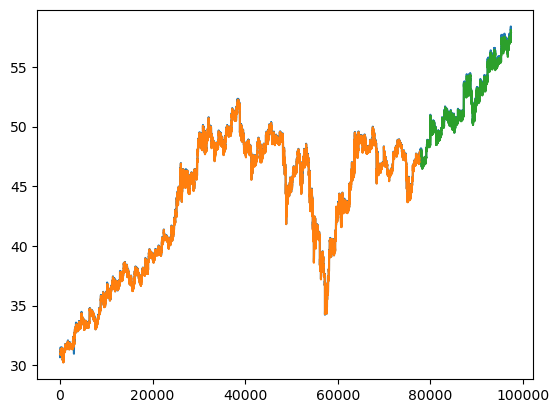

In [27]:
# visualization
# shift train pred for plotting
look_back = 100
trainPredPlot = np.empty_like(df1)
trainPredPlot[:, :] = np.nan
trainPredPlot[look_back:len(train_pred)+look_back, :] = train_pred
# shift test predictions for plotting
testPredPlot = np.empty_like(df1)
testPredPlot[:, :] = np.nan
testPredPlot[len(train_pred)+(look_back*2)+1:len(df1)-1, :] = test_pred
# plot baseline and predictions
plt.plot(scaler.inverse_transform(df1))
plt.plot(trainPredPlot)
plt.plot(testPredPlot)
plt.show()

# Demonstrate pred for next n minutes in a day 

In [28]:
len(test_data)

19482

In [29]:
x_input = test_data[19348:].reshape(1,-1)
x_input.shape

(1, 134)

In [30]:
x_input

array([[0.96447602, 0.96447602, 0.96447602, 0.96447602, 0.96447602,
        0.96447602, 0.96092362, 0.96447602, 0.96447602, 0.96447602,
        0.96447602, 0.96092362, 0.96447602, 0.96092362, 0.96092362,
        0.96092362, 0.96092362, 0.96447602, 0.96447602, 0.96447602,
        0.96447602, 0.96447602, 0.96447602, 0.96802842, 0.97868561,
        0.97158082, 0.97158082, 0.97513321, 0.97513321, 0.97158082,
        0.97158082, 0.97513321, 0.97158082, 0.96802842, 0.96802842,
        0.96802842, 0.96802842, 0.96802842, 0.96802842, 0.96802842,
        0.96447602, 0.96802842, 0.96092362, 0.96092362, 0.96447602,
        0.96447602, 0.96447602, 0.96447602, 0.96447602, 0.96447602,
        0.96447602, 0.96802842, 0.96802842, 0.97158082, 0.97158082,
        0.97158082, 0.97158082, 0.97158082, 0.96802842, 0.96802842,
        0.97158082, 0.97158082, 0.97158082, 0.97158082, 0.97513321,
        0.97158082, 0.97158082, 0.97158082, 0.97158082, 0.97158082,
        0.97158082, 0.97158082, 0.97158082, 0.96

In [31]:
temp_input = list(x_input)
temp_input = temp_input[0].tolist()

In [32]:
temp_input

[0.9644760213143873,
 0.9644760213143873,
 0.9644760213143873,
 0.9644760213143873,
 0.9644760213143873,
 0.9644760213143873,
 0.960923623445826,
 0.9644760213143873,
 0.9644760213143873,
 0.9644760213143873,
 0.9644760213143873,
 0.960923623445826,
 0.9644760213143873,
 0.960923623445826,
 0.960923623445826,
 0.960923623445826,
 0.960923623445826,
 0.9644760213143873,
 0.9644760213143873,
 0.9644760213143873,
 0.9644760213143873,
 0.9644760213143873,
 0.9644760213143873,
 0.9680284191829489,
 0.9786856127886325,
 0.9715808170515101,
 0.9715808170515101,
 0.9751332149200713,
 0.9751332149200713,
 0.9715808170515101,
 0.9715808170515101,
 0.9751332149200713,
 0.9715808170515101,
 0.9680284191829489,
 0.9680284191829489,
 0.9680284191829489,
 0.9680284191829489,
 0.9680284191829489,
 0.9680284191829489,
 0.9680284191829489,
 0.9644760213143873,
 0.9680284191829489,
 0.960923623445826,
 0.960923623445826,
 0.9644760213143873,
 0.9644760213143873,
 0.9644760213143873,
 0.9644760213143873,


In [33]:
len(temp_input)

134

In [34]:
# a day the stock prices was recorded from 9.15 am to 2.46 pm, about 134 minutes
lst_output=[]
n_steps=134
i = 0
while(i<134):
    
    if(len(temp_input)>134):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} minutes input {}".format(i+1,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} minutes output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1

print(lst_output)

[0.98030484]
135
2 minutes input [0.96447602 0.96447602 0.96447602 0.96447602 0.96447602 0.96092362
 0.96447602 0.96447602 0.96447602 0.96447602 0.96092362 0.96447602
 0.96092362 0.96092362 0.96092362 0.96092362 0.96447602 0.96447602
 0.96447602 0.96447602 0.96447602 0.96447602 0.96802842 0.97868561
 0.97158082 0.97158082 0.97513321 0.97513321 0.97158082 0.97158082
 0.97513321 0.97158082 0.96802842 0.96802842 0.96802842 0.96802842
 0.96802842 0.96802842 0.96802842 0.96447602 0.96802842 0.96092362
 0.96092362 0.96447602 0.96447602 0.96447602 0.96447602 0.96447602
 0.96447602 0.96447602 0.96802842 0.96802842 0.97158082 0.97158082
 0.97158082 0.97158082 0.97158082 0.96802842 0.96802842 0.97158082
 0.97158082 0.97158082 0.97158082 0.97513321 0.97158082 0.97158082
 0.97158082 0.97158082 0.97158082 0.97158082 0.97158082 0.97158082
 0.96802842 0.97158082 0.96802842 0.96802842 0.96802842 0.97158082
 0.97158082 0.96802842 0.97158082 0.97158082 0.96802842 0.96802842
 0.97158082 0.96802842 0.9715

In [35]:
df1.shape

(97406, 1)

In [36]:
test_data.shape

(19482, 1)

In [37]:
len(lst_output)

134

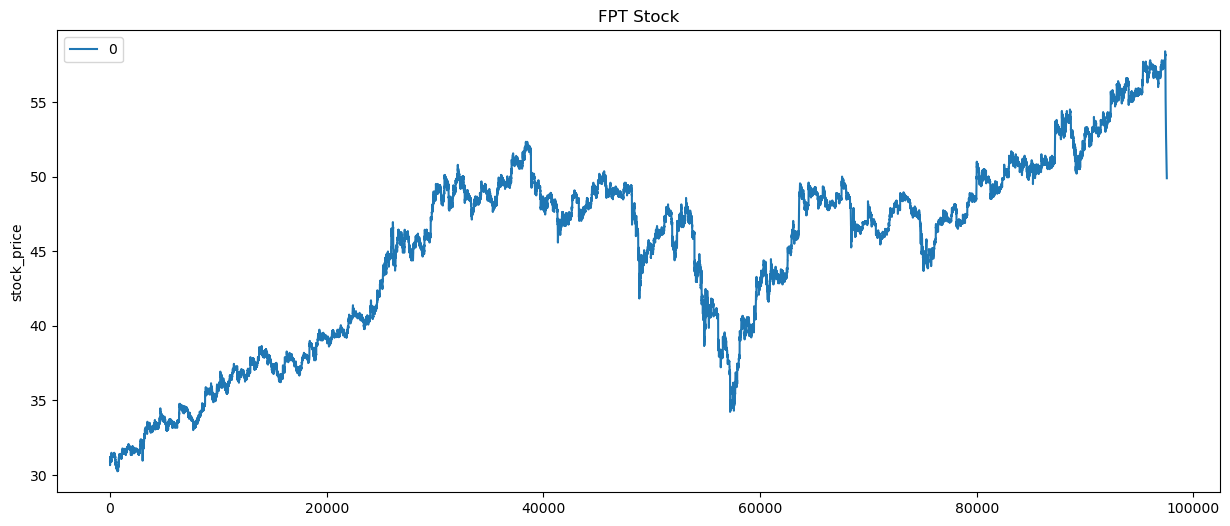

In [41]:
df3 = pd.DataFrame(df3)
df3.plot(figsize=(15, 6))
plt.ylabel("stock_price")
plt.title("FPT Stock")
plt.show()